In [1]:
import opendatasets as od
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torchvision.utils import save_image
from tqdm import tqdm
import torch.nn.functional as F
from IPython.display import Image
import cv2
import os

In [2]:
class Discriminator():
    def __init__(self, g1):
#         super().__init__()
        self.g1 = g1
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

            nn.Flatten(),
            nn.Sigmoid())

class Generator():
    def __init__(self, g1):
#         super().__init__()
        self.g1 = g1
        self.network = nn.Sequential(
        nn.ConvTranspose2d(g1.latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

In [3]:
class DeviceDataLoader():
    def __init__(self, f1, dl, device):
        self.dl = dl
        self.device = device
        self.f1 = f1
        
    def __iter__(self):
        for b in self.dl: 
            yield self.f1.to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [64]:
class GAN():
    def __init__(self):
        print("constructor")
        
    def init_hyp(self):
        self.image_size = 64
        self.batch_size = 128
        self.stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        self.latent_size = 128
        self.lr = 0.0002
        self.epoch = 25
        
    def get_data(self):
        dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
        od.download(dataset_url)
        
    def show_data(self):
        self.DATA_DIR = './data/animefacedataset'
        print(os.listdir(self.DATA_DIR+'/images')[:10])
    
    def init_data(self):
        self.init_hyp()
        self.disc = Discriminator(self).network
        self.genr = Generator(self).network
        self.device = self.get_default_device()
        self.to_device(self.disc, self.device)
        self.to_device(self.genr, self.device)
        self.fixed_latent = torch.randn(64, self.latent_size, 1, 1, device=self.device)
        
        self.train_ds = ImageFolder(self.DATA_DIR, transform=T.Compose([
        T.Resize(self.image_size),
        T.CenterCrop(self.image_size),
        T.ToTensor(),
        T.Normalize(*self.stats)]))

        self.train_dl_cpu = DataLoader(self.train_ds, self.batch_size, shuffle=True, num_workers=4, pin_memory=True)
        self.train_dl = DeviceDataLoader(self, self.train_dl_cpu, self.device)
    
    def denorm(self, img_tensors):
        return img_tensors * self.stats[1][0] + self.stats[0][0]
    
    def show_images(self, images, nmax=64):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(self.denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

    def show_batch(self, nmax=64):
        for images, _ in self.train_dl_cpu:
            self.show_images(images, nmax)
            break
    
    def get_default_device(self):
        if torch.cuda.is_available():
            return torch.device('cuda')
        else:
            return torch.device('cpu')
    
    def to_device(self, data, device):
        if isinstance(data, (list,tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    def train_discriminator(self, real_images, opt_d):
        opt_d.zero_grad()

        real_preds = self.disc(real_images)
        real_targets = torch.ones(real_images.size(0), 1, device=self.device)
        real_loss = F.binary_cross_entropy(real_preds, real_targets)
        real_score = torch.mean(real_preds).item()

        latent = torch.randn(self.batch_size, self.latent_size, 1, 1, device=self.device)
        fake_images = self.genr(latent)

        fake_targets = torch.zeros(fake_images.size(0), 1, device=self.device)
        fake_preds = self.disc(fake_images)
        fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
        fake_score = torch.mean(fake_preds).item()

        loss = real_loss + fake_loss
        loss.backward()
        opt_d.step()
        return loss.item(), real_score, fake_score
    
    def train_generator(self, opt_g):
        # Clear generator gradients
        opt_g.zero_grad()

        # Generate fake images
        latent = torch.randn(self.batch_size, self.latent_size, 1, 1, device=self.device)
        fake_images = self.genr(latent)

        # Try to fool the discriminator
        preds = self.disc(fake_images)
        targets = torch.ones(self.batch_size, 1, device=self.device)
        loss = F.binary_cross_entropy(preds, targets)

        # Update generator weights
        loss.backward()
        opt_g.step()

        return loss.item()
    
    def save_samples(self, index, latent_tensors, show=True):
        sample_dir = './data/animefacedataset/generated'
        os.makedirs(sample_dir, exist_ok=True)
        
        fake_images = self.genr(latent_tensors)
        fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
        save_image(self.denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
        print('Saving', fake_fname)
        if show:
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    
    def fit(self, start_idx=1):
        torch.cuda.empty_cache()

        # Losses & scores
        losses_g = []
        losses_d = []
        real_scores = []
        fake_scores = []

        # Create optimizers
        opt_d = torch.optim.Adam(self.disc.parameters(), lr=self.lr, betas=(0.5, 0.999))
        opt_g = torch.optim.Adam(self.genr.parameters(), lr=self.lr, betas=(0.5, 0.999))

        for epoch in range(self.epoch):
            for real_images, _ in tqdm(self.train_dl, position=0, leave=True):
                # Train discriminator
                loss_d, real_score, fake_score = self.train_discriminator(real_images, opt_d)
                # Train generator
                loss_g = self.train_generator(opt_g)

            # Record losses & scores
            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            # Log losses & scores (last batch)
            print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch+1, self.epoch, loss_g, loss_d, real_score, fake_score))

            # Save generated images
            self.save_samples(epoch+start_idx, self.fixed_latent, show=False)

        return losses_g, losses_d, real_scores, fake_scores

In [65]:
gan = GAN()

constructor


In [66]:
gan.show_data()

['21313_2008.jpg', '59138_2018.jpg', '17166_2007.jpg', '1381_2001.jpg', '50323_2015.jpg', '37898_2012.jpg', '15373_2006.jpg', '8471_2004.jpg', '17680_2007.jpg', '17820_2007.jpg']


In [67]:
gan.init_data()

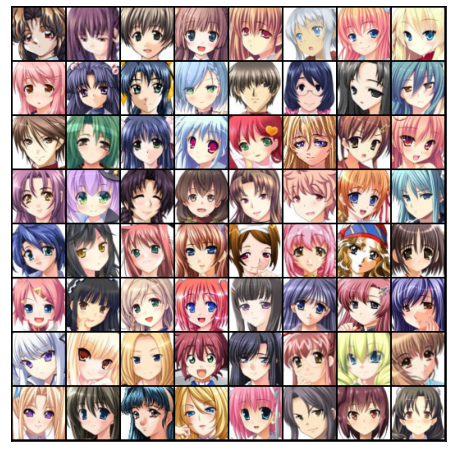

In [68]:
gan.show_batch()

In [69]:
history = gan.fit()

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 2.8374, loss_d: 0.2938, real_score: 0.8751, fake_score: 0.1295
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 4.5565, loss_d: 0.4622, real_score: 0.7688, fake_score: 0.1376
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 3.3165, loss_d: 0.2421, real_score: 0.9213, fake_score: 0.1347
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 10.7956, loss_d: 0.8979, real_score: 0.5522, fake_score: 0.0001
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 5.6922, loss_d: 0.0473, real_score: 0.9594, fake_score: 0.0037
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 6.1834, loss_d: 0.2907, real_score: 0.9370, fake_score: 0.1719
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 4.8076, loss_d: 0.1784, real_score: 0.8739, fake_score: 0.0328
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 2.3864, loss_d: 1.4866, real_score: 0.3298, fake_score: 0.0003
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 6.9548, loss_d: 0.1490, real_score: 0.9328, fake_score: 0.0481
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 4.4256, loss_d: 0.4127, real_score: 0.7347, fake_score: 0.0037
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 4.5144, loss_d: 0.1206, real_score: 0.9100, fake_score: 0.0157
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 3.9259, loss_d: 0.1341, real_score: 0.9206, fake_score: 0.0431
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 3.7836, loss_d: 0.2111, real_score: 0.8674, fake_score: 0.0416
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 3.3286, loss_d: 0.3445, real_score: 0.7526, fake_score: 0.0063
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 4.6426, loss_d: 0.1014, real_score: 0.9559, fake_score: 0.0507
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 3.1627, loss_d: 0.1926, real_score: 0.8740, fake_score: 0.0386
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.6028, loss_d: 0.2580, real_score: 0.9020, fake_score: 0.1240
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.1677, loss_d: 0.5071, real_score: 0.9331, fake_score: 0.2873
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 5.2058, loss_d: 0.1286, real_score: 0.9552, fake_score: 0.0750
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 4.8894, loss_d: 0.0950, real_score: 0.9433, fake_score: 0.0264
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 4.9657, loss_d: 0.0641, real_score: 0.9761, fake_score: 0.0375
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 3.7274, loss_d: 0.1372, real_score: 0.9111, fake_score: 0.0344
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 1.9240, loss_d: 0.9828, real_score: 0.5122, fake_score: 0.0124
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 4.5433, loss_d: 0.0951, real_score: 0.9604, fake_score: 0.0451
Saving generated-images-0024.png


100%|██████████| 497/497 [01:08<00:00,  7.26it/s]


Epoch [25/25], loss_g: 4.8766, loss_d: 0.6740, real_score: 0.9267, fake_score: 0.3813
Saving generated-images-0025.png
